In [ ]:
pip install plotly==5.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
pip install nbformat>=4.2.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

import pandas as pd
import plotly.express as px

import csv
import re

# 1. Defintions for Target functions

We can add more custom functions and add them to the function_list in the next cell for fitting these new target functions.

In [ ]:
###############################################################################
# Target Function definitons
###############################################################################

def default_funct(x, y):
    return np.real(-0.02 + 0.04*np.cos(2*x + y) + 0.25*np.sin(x) - 0.3*np.cos(2*y) - 0.1*np.sin(x - y))

def func_poly(x, y):
    """A random polynomial style function"""
    return 0.1*x**2 - 0.2*y + 0.3*x*y - 0.4*x + 2.0

def func_sinc(x, y):
    """2D "sinc"-like function"""
    r = np.sqrt(x**2 + y**2) + 1e-9
    return np.sin(r)/r

def func_random_trig(x, y):
    """Random trig combos with random seeds."""
    # For demonstration, pick random coefficients:
    rng = np.random.RandomState(123)
    a1, a2, a3 = rng.uniform(-1,1,3)
    b1, b2, b3 = rng.uniform(-1,1,3)
    return a1*np.sin(x) + a2*np.cos(y) + b1*np.sin(2*x + 0.5*y) + b2*np.cos(2*y - 0.3*x) + a3*x + b3*y

def func_big_trig(x, y):
    """
    A multi-term trigonometric function with various frequencies.
    """
    return (
        0.7 * np.sin(0.5*x) +
        0.4 * np.sin(2.2*y) -
        0.3 * np.cos(2.0*x + 1.3*y) +
        0.25* np.sin(1.5*x - 0.8*y) +
        0.15* np.cos(0.9*x + 2.1*y) +
        0.05* np.sin(3.0*x + 0.2*y)
    )
def func_combined_oscillator(x, y):
    """
    Another mix of sine and cosine with phase offsets, plus a small polynomial part.
    """
    return (
        0.05*x**2 - 0.1*y +         # mild polynomial part
        0.6*np.cos(1.2*x + 0.5*y) -
        0.4*np.sin(0.8*x - 1.3*y) +
        0.35*np.cos(2*x) +
        0.2*np.sin(2*y)
    )
def func_random_trig2(x, y, seed=123):
    """
    Generate a random multi-term trig function based on a fixed seed, so it
    produces the same pattern each time but is less 'hand-crafted'.
    """
    rng = np.random.RandomState(seed)

    # Some random frequencies in [0.5..2.5]
    freq_x = rng.uniform(0.5, 2.5, size=3)
    freq_y = rng.uniform(0.5, 2.5, size=3)

    # Random amplitude scaling in [-1..1]
    amp = rng.uniform(-1, 1, size=6)

    # We'll build 3 sine terms and 3 cos terms:
    val = 0.0
    val += amp[0]*np.sin(freq_x[0]*x + freq_y[0]*y)
    val += amp[1]*np.cos(freq_x[1]*x - freq_y[1]*y)
    val += amp[2]*np.sin(freq_x[2]*x - freq_y[2]*y)
    val += amp[3]*np.cos(0.3*x + 1.2*y)
    val += amp[4]*np.sin(1.1*x - 2.0*y)
    val += amp[5]*np.cos(2.2*x + 0.7*y)

    return val
def func_freq_soup(x, y):
    """
    A function that tries combining multiple discrete frequencies in x and y,
    reminiscent of a partial Fourier series.
    """
    val = (  # We'll combine 2D expansions: kx in [1..3], ky in [1..3]
        0.3*np.sin(1*x + 2*y) +
        0.2*np.cos(2*x + 1*y) +
        0.15*np.sin(3*x + 3*y) +
        0.1*np.cos(1*x - 3*y) +
        0.05*np.sin(2*x - 2*y)
    )
    return val

def func_peaks_trig(x, y):
    """
    Produces multiple 'peaks' by combining sines/cosines on different frequencies
    and small offsets.
    """
    return (
        0.5 * np.cos(1.3*x - 0.5*y)
        + 0.4 * np.sin(2.1*x + 0.7*y)
        - 0.3 * np.cos(3.0*x - 2.2*y)
        + 0.2 * np.sin(1.1*x - 3.0*y)
        + 0.1 * np.cos(0.6*x + 0.3*y)
    )

def func_spiral_mix(x, y):
    """
    A swirl/spiral-like pattern from combining rotational/trig cross-terms
    and mild polynomial offset.
    """
    r = np.sqrt(x**2 + y**2) + 1e-9
    theta = np.arctan2(y, x)
    # Combine radial + angular trig:
    val = (
        0.1*r                      # mild radial slope
        + 0.5*np.sin(2.0*theta)    # swirl factor
        + 0.25*np.cos(3.0*theta)
        - 0.2*np.sin(0.5*x - 0.8*y)
        + 0.05*r*np.cos(5*theta)
    )
    return val

def func_random_fourier(x, y, max_freq=3, seed=42):
    """
    Generates a random partial 2D Fourier series with integer frequencies
    in [1..max_freq] for x,y.
    You can expand or reduce max_freq as needed.
    """
    rng = np.random.RandomState(seed)
    val = np.zeros_like(x, dtype=float)

    # We'll pick random coefficients for cos(kx*x + ky*y) and sin(kx*x + ky*y).
    # For each kx in [1..max_freq], ky in [1..max_freq], we add random cos & sin terms.
    for kx in range(1, max_freq+1):
        for ky in range(1, max_freq+1):
            # random amplitude for cos, sin
            A_cos = rng.uniform(-1,1)
            A_sin = rng.uniform(-1,1)
            # random small phase offset
            phase = rng.uniform(0, 2*np.pi)

            # cos(kx*x + ky*y + phase)
            val += A_cos * np.cos(kx*x + ky*y + phase)
            # sin(kx*x + ky*y - phase)
            val += A_sin * np.sin(kx*x + ky*y - phase)

    return val

def func_large_amplitude_mix(x, y):
    """
    A heavier amplitude mix of sines and cosines that might be
    especially challenging for small qubit models.
    """
    return (
        2.5*np.sin(1.2*x + 0.7*y)
        - 2.0*np.cos(0.6*x - 1.1*y)
        + 1.5*np.sin(2.0*x - 2.5*y)
        + 0.8*np.cos(3.0*x + 2.0*y)
        - 0.3*np.sin(4.0*x - 0.2*y)
    )

def func_cross_terms(x, y):
    """
    A function that heavily mixes x, y cross-terms inside trig.
    """
    return (
        np.sin(x + y)
        + 0.5*np.cos(2*x - y)
        - 0.4*np.sin(3*y + 2.1*x)
        + 0.3*np.cos(1.2*x - 2.5*y)
        + 0.2*x*np.sin(y)         # mild nonlinear cross term
    )

## 2.1 Set which target functons we wanna fit, quantum model specs and the window size range

Note: ETA for training all 13 functions for the window size range (1,21) is over 7 hrs.

So it would be better to see performance for each function one at a time for convenience. I already have a csv file for the training output of the whole 13 functions fitting. We can simply upload this csv file to colab and run the plot analysis section directly. There is also a separate code cell at the end with these data from the csv files to run it immediately.

In [ ]:
# List of functions
# Comment out functions we dont wanna fit
# Training to fit all the functions below will have an ETA of 7hrs, so its preferred to train at the functions we are interested in alone
function_list = [
    ("Default Function", default_funct),
    ("Polynomial", func_poly),
    ("Sinc", func_sinc),
    ("Random Trig", func_random_trig),
    ("Big Trig", func_big_trig),
    ("Combined Oscillator", func_combined_oscillator),
    ("Random Trig 2", func_random_trig2),
    ("Freq Soup", func_freq_soup),
    ("Peaks Trig", func_peaks_trig),
    ("Spiral Mix", func_spiral_mix),
    ("Random Fourier", func_random_fourier),
    ("Large Amp Mix", func_large_amplitude_mix),
    ("CrossTerms",       func_cross_terms),
]

print(f"Number of functions to fit: {len(function_list)}")

# Quantum model specs
layers = 2
ansatz = 6
qubits = 1
test_samples = 1500
train_samples = 500

# window size range
window_sizes = list(range(1, 21))  # from 1 up to 20

Number of functions to fit: 13


## 2.2 Plot Target functions from the function list

We can have a preview of the target functions we selected fr fitting before passing it to the quantum model

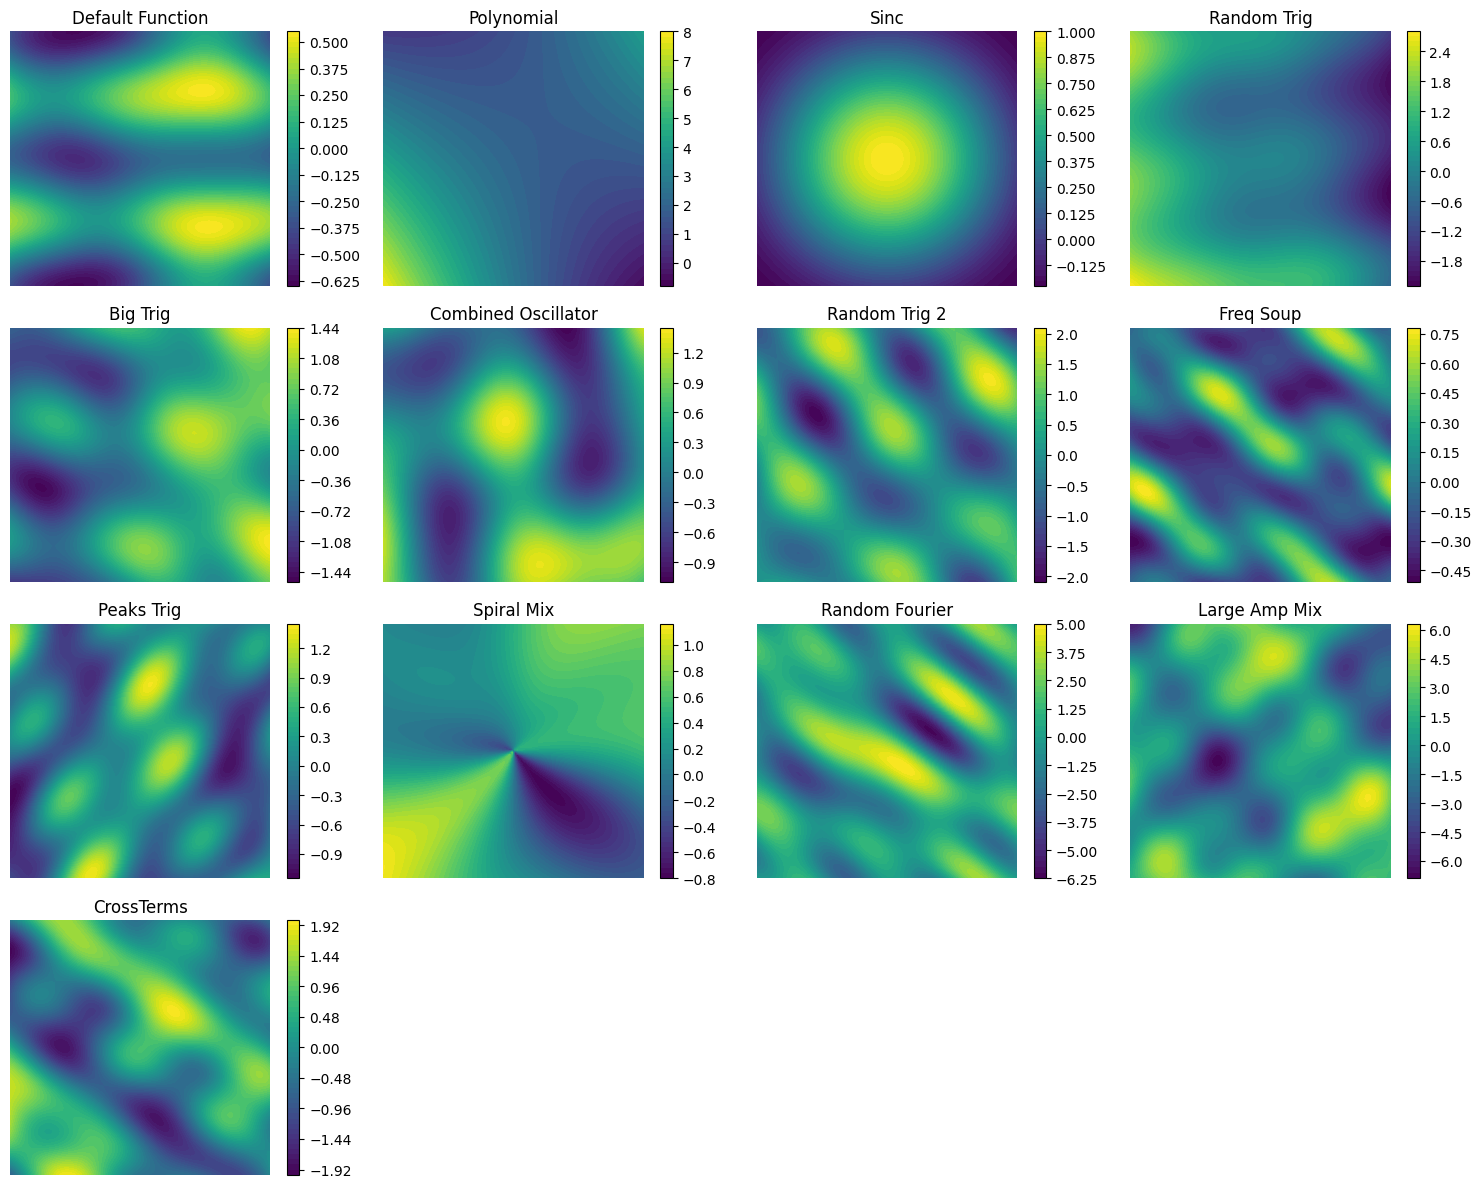

In [ ]:
# Grid for plotting
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
X, Y = np.meshgrid(x, y)

# Plotting
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # Increae these values in case even more target functions are being plotted
axes = axes.flatten()

for i, (name, func) in enumerate(function_list):
    if name == "Random Fourier":
        Z = func(X, Y, max_freq=3, seed=42)
    else:
        Z = func(X, Y)
    ax = axes[i]
    c = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    fig.colorbar(c, ax=ax)
    ax.set_title(name)
    ax.axis("off")

# Hide any unused subplots
for j in range(len(function_list), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# 3. Training code

# 25 evaluations of the local quantum surrogate regardless of the window size

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║   Quantum → Classical local-surrogate benchmark (STRICT Eisert version)  ║
# ╚══════════════════════════════════════════════════════════════════════════╝
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  scipy.optimize import minimize
from  itertools       import product

# ────────────────────── 0 ---  test-bed functions ─────────────────────────
#  (define/​import your analytical 2-D targets here)
# function_list = [
#     ("Default Function" ,       default_funct),
#     ("Random Trig 2"    ,       func_random_trig2),
#     ("Freq Soup"        ,       func_freq_soup),
#     ("Peaks Trig"       ,       func_peaks_trig),
#     ("Spiral Mix"       ,       func_spiral_mix),
#     ("Random Fourier"   ,       func_random_fourier),
#     ("Large Amp Mix"    ,       func_large_amplitude_mix),
#     ("CrossTerms"       ,       func_cross_terms),
# ]
function_list = [
    ("Default Function", default_funct),
    ("Polynomial", func_poly),
    ("Sinc", func_sinc),
    ("Random Trig", func_random_trig),
    ("Big Trig", func_big_trig),
    ("Combined Oscillator", func_combined_oscillator),
    ("Random Trig 2", func_random_trig2),
    ("Freq Soup", func_freq_soup),
    ("Peaks Trig", func_peaks_trig),
    ("Spiral Mix", func_spiral_mix),
    ("Random Fourier", func_random_fourier),
    ("Large Amp Mix", func_large_amplitude_mix),
    ("CrossTerms",       func_cross_terms),
]
print(f"# functions to fit = {len(function_list)}")

# ═════════════════════════════════════════════════════════════════════════════
# 1.  Quantum re-uploading “black-box” (single-qubit)   – unchanged
# ═════════════════════════════════════════════════════════════════════════════
class FittingQubit:
    """Minimal 1-qubit feature-reuploading model (depth=L, ansatz=6)."""
    def __init__(self, L, ansatz, f_target,
                 train_samples=500, seed=7,
                 start_xy=(0,0), window_size=None):
        np.random.seed(seed)
        self.L, self.ansatz = L, ansatz
        self.f_target = f_target

        N = int(np.sqrt(train_samples))
        x = np.linspace(-np.pi, np.pi, N)
        self.xtrain = np.meshgrid(x, x)
        self.Ftrain = f_target(self.xtrain[0], self.xtrain[1])

        if window_size is not None:
            sx, sy = start_xy
            ex, ey = sx+window_size, sy+window_size
            self.xpatch = (self.xtrain[0][sx:ex, sy:ey],
                           self.xtrain[1][sx:ex, sy:ey])
            self.Fpatch = self.Ftrain[sx:ex, sy:ey]
        else:                                # full grid
            self.xpatch, self.Fpatch = self.xtrain, self.Ftrain

        self.params = np.random.uniform(size=(L+1, ansatz))

    # ­-- elementary gates
    @staticmethod
    def _gate(name, θ):
        j = 1j
        if name=='Ry':
            return np.array([[np.cos(θ/2),  np.sin(θ/2)],
                             [-np.sin(θ/2), np.cos(θ/2)]], dtype=complex)
        if name=='Rz':
            return np.array([[np.exp(j*θ/2), 0],
                             [0, np.exp(-j*θ/2)]], dtype=complex)

    # ­-- circuit expectation ⟨Z⟩ for one point
    # def circuit(self, x):
    #     state = np.array([1,0], dtype=complex)
    #     p     = self.params
    #     # first layer
    #     for g,θ in zip('RzRyRz', p[0]): state = self._gate(g,θ) @ state
    #     # feature-reuploading blocks
    #     for layer in p[1:]:
    #         for g,θ in zip('RzRzRyRz', [x[0], *layer[:3]]): state = self._gate(g,θ) @ state
    #         for g,θ in zip('RzRzRyRz', [x[1], *layer[3:]]): state = self._gate(g,θ) @ state
    #     return np.abs(state[0])**2 - np.abs(state[1])**2
    # ── inside class FittingQubit ────────────────────────────────────────────
    def circuit(self, x):
        state = np.array([1, 0], dtype=complex)
        p     = self.params

        # layer 0  (3 trainable angles)
        for g, θ in zip(['Rz', 'Ry', 'Rz'], p[0]):
            state = self._gate(g, θ) @ state

        # feature-reuploading blocks
        for layer in p[1:]:
            # encode x1 then three trainable angles
            for g, θ in zip(['Rz', 'Rz', 'Ry', 'Rz'], [x[0], *layer[:3]]):
                state = self._gate(g, θ) @ state
            # encode x2 then three trainable angles
            for g, θ in zip(['Rz', 'Rz', 'Ry', 'Rz'], [x[1], *layer[3:]]):
                state = self._gate(g, θ) @ state

        return np.abs(state[0])**2 - np.abs(state[1])**2


    # ­-- patch-MSE cost
    def _cost(self, flat=None):
        if flat is not None: self.params = flat.reshape(self.L+1, self.ansatz)
        X1, X2 = self.xpatch
        pred   = np.vectorize(lambda a,b: self.circuit((a,b)))(X1, X2)
        return np.mean((self.Fpatch - pred)**2)

    # ­-- Nelder-Mead train
    def train(self, **opt_kw):
        res = minimize(self._cost, self.params.flatten(),
                       method='Nelder-Mead', options=opt_kw)
        self.params = res.x.reshape(self.L+1, self.ansatz)
        return res.fun

# ═════════════════════════════════════════════════════════════════════════════
# 2.  Fourier helper – exact Eisert cube  and   adaptive (old) basis
# ═════════════════════════════════════════════════════════════════════════════
def fourier_cube_matrix(coords, L):
    """Full tensor-product exp(i(k₁x+k₂y)) for |k₁|,|k₂|≤L (size N × (2L+1)²)."""
    k = np.arange(-L, L+1)
    K = np.array(list(product(k, k)))                  # ((2L+1)², 2)
    return np.exp(1j * coords @ K.T)                   # complex design matrix

def fourier_separable_matrix(coords, kmax):
    """Old separable cos/sin basis  (1+4kmax columns)."""
    N = coords.shape[0]
    cols = 1 + 4*kmax
    A = np.zeros((N, cols))
    for i,(x,y) in enumerate(coords):
        j   = 0
        A[i,j] = 1.0; j += 1
        for k in range(1, kmax+1):
            A[i, j:j+2] = [np.cos(k*x), np.sin(k*x)]; j += 2
        for k in range(1, kmax+1):
            A[i, j:j+2] = [np.cos(k*y), np.sin(k*y)]; j += 2
    return A

# ── helper to build the  (2L+1)×(2L+1)  lattice INSIDE the current patch ──
def eisert_lattice(X1_patch, X2_patch, L):
    """
    Returns a 25×2 array of (x,y) coordinates obtained by rescaling the
    canonical 5×5 grid onto the rectangular patch spanned by X1_patch, X2_patch.
    Assumes X*_patch are    shape == (w, w)   with monotone axes.
    """
    # 1. axis limits of the square patch
    x_min, x_max = X1_patch[0, 0], X1_patch[0, -1]
    y_min, y_max = X2_patch[0, 0], X2_patch[-1, 0]

    # 2. equispaced  (2L+1)  knots along each axis
    grid_x = np.linspace(x_min, x_max, 2*L + 1)
    grid_y = np.linspace(y_min, y_max, 2*L + 1)

    # 3. Cartesian product → 25 lattice points
    return np.array([(u, v) for u in grid_x for v in grid_y])   # (25, 2)


# ═════════════════════════════════════════════════════════════════════════════
# 3.  Main experiment
# ═════════════════════════════════════════════════════════════════════════════
window_sizes     = list(range(2, 20))
L, ansatz, qubit = 2, 6, 1
train_N          = 500

records = []
for name, f in function_list:
    print(f"\n🟢 Function: {name}")
    for w in window_sizes:
        print(f"  ▸ window = {w}")
        Q = FittingQubit(L, ansatz, f,
                         train_samples=train_N,
                         start_xy=(2,2), window_size=w)
        Q.train(maxiter=10_000, disp=False)

        # ── data   (flat arrays) ────────────────────────────────────────────
        X1p, X2p = Q.xpatch
        coords   = np.vstack([X1p.flatten(), X2p.flatten()]).T
        y_target = Q.Fpatch.flatten()
        y_quant  = np.array([Q.circuit(pt) for pt in coords])

        # ── strict-Eisert surrogate on the quantum model ──────────────────────────
        #     • exactly 25 quantum evaluations (5×5 lattice)
        #     • square design matrix 25×25  → unique solution
        coords_eis = eisert_lattice(X1p, X2p, L)          # (25, 2) points
        y_quant_eis = np.array([Q.circuit(pt)             # 25 circuit calls
                                for pt in coords_eis])

        A_q = fourier_cube_matrix(coords_eis, L)          # shape (25, 25)
        α_q = np.linalg.solve(A_q, y_quant_eis)           # exact (square)

        # ­--- quality metric (evaluate surrogate on the ENTIRE patch,     ­---
        #      *only* for reporting; does not change the training budget) ----
        yq_fit   = (fourier_cube_matrix(coords, L) @ α_q).real
        r2_cq    = 1 - np.sum((y_quant - yq_fit)**2) / np.sum((y_quant - y_quant.mean())**2)


        # ── Classical fit on target  (adaptive separable) ──────────────────
        k_adapt = max(1, round(w/2))                            # heuristic rule
        A_t     = fourier_separable_matrix(coords, k_adapt)
        α_t     = np.linalg.lstsq(A_t, y_target, rcond=None)[0]
        yt_fit  = A_t @ α_t
        r2_ct   = 1 - np.sum((y_target - yt_fit)**2)/np.sum((y_target - y_target.mean())**2)

        # ── Quantum R² vs target  (for reference) ──────────────────────────
        r2_qt = 1 - np.sum((y_target - y_quant)**2)/np.sum((y_target - y_target.mean())**2)

        print(f"     R²  quantum→target  : {r2_qt:6.4f}")
        print(f"     R²  class.→target   : {r2_ct:6.4f}")
        print(f"     R²  class.→quantum  : {r2_cq:6.4f}")

        records.append(dict(func=name, win=w,
                            r2_qt=r2_qt, r2_ct=r2_ct, r2_cq=r2_cq))

# ═════════════════════════════════════════════════════════════════════════════
# 4.  Results dataframe & plots
# ═════════════════════════════════════════════════════════════════════════════
df = pd.DataFrame(records)
df.to_csv("q2c_surrogation_results.csv", index=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
for fn in df.func.unique():
    sub = df[df.func==fn]
    ax1.plot(sub.win, sub.r2_qt, 'o-',  label=f'{fn} Q→T')
    ax1.plot(sub.win, sub.r2_ct, 's--', label=f'{fn} C→T')
    ax2.plot(sub.win, sub.r2_cq, 'd-',  label=f'{fn} C→Q')
ax1.set(xlabel='Window size w', ylabel='R² vs target', title='Quantum & Classical vs target')
ax2.set(xlabel='Window size w', ylabel='R² (classical vs quantum)', title='Eisert surrogate')
for ax in (ax1,ax2): ax.grid(True); ax.legend()
ax2.axhline(0.9,color='r',ls='--')
plt.tight_layout(); plt.show()

# functions to fit = 13

🟢 Function: Default Function
  ▸ window = 2
     R²  quantum→target  : 0.9362
     R²  class.→target   : 0.9999
     R²  class.→quantum  : 1.0000
  ▸ window = 3
     R²  quantum→target  : 0.9999
     R²  class.→target   : 0.9994
     R²  class.→quantum  : 1.0000
  ▸ window = 4
     R²  quantum→target  : 0.9981
     R²  class.→target   : 0.9984
     R²  class.→quantum  : 1.0000
  ▸ window = 5
     R²  quantum→target  : 0.9981
     R²  class.→target   : 0.9972
     R²  class.→quantum  : 1.0000
  ▸ window = 6
     R²  quantum→target  : 0.9919
     R²  class.→target   : 0.9961
     R²  class.→quantum  : 1.0000
  ▸ window = 7
     R²  quantum→target  : 0.9928
     R²  class.→target   : 0.9948
     R²  class.→quantum  : 1.0000
  ▸ window = 8
     R²  quantum→target  : 0.9932
     R²  class.→target   : 0.9909
     R²  class.→quantum  : 1.0000
  ▸ window = 9
     R²  quantum→target  : 0.9743
     R²  class.→target   : 0.9848
     R²  class.→quantum  : 1.0000
  ▸ window

# Plot analysis

In [ ]:
import pandas as pd
import plotly.express as px

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Paste your text dumps here
# ─────────────────────────────────────────────────────────────────────────────
RAW_Q2T = """
function_name,window_size,value
Default Function,2,0.9362
Default Function,3,0.9999
Default Function,4,0.9981
Default Function,5,0.9981
Default Function,6,0.9919
Default Function,7,0.9928
Default Function,8,0.9932
Default Function,9,0.9743
Default Function,10,0.9009
Default Function,11,0.5297
Default Function,12,0.5176
Default Function,13,0.4749
Default Function,14,0.4419
Default Function,15,0.4345
Default Function,16,0.4419
Default Function,17,0.4489
Default Function,18,0.4417
Default Function,19,0.4183
Polynomial,2,-294.5016
Polynomial,3,-103.5736
Polynomial,4,-51.8014
Polynomial,5,-30.3692
Polynomial,6,-19.5483
Polynomial,7,-13.3979
Polynomial,8,-9.6145
Polynomial,9,-7.1521
Polynomial,10,-5.4812
Polynomial,11,-4.3113
Polynomial,12,-3.4723
Polynomial,13,-2.8600
Polynomial,14,-2.4073
Polynomial,15,-2.0694
Polynomial,16,-1.8148
Polynomial,17,-1.6199
Polynomial,18,-1.4660
Polynomial,19,-1.3372
Sinc,2,1.0000
Sinc,3,0.9996
Sinc,4,0.9990
Sinc,5,0.9992
Sinc,6,0.9947
Sinc,7,0.9966
Sinc,8,0.9897
Sinc,9,0.9706
Sinc,10,0.9966
Sinc,11,0.9964
Sinc,12,0.9964
Sinc,13,0.9965
Sinc,14,0.6361
Sinc,15,0.5771
Sinc,16,0.5394
Sinc,17,0.5182
Sinc,18,0.5058
Sinc,19,0.4948
Random Trig,2,-7.5356
Random Trig,3,-1.0586
Random Trig,4,0.1945
Random Trig,5,0.5962
Random Trig,6,0.7549
Random Trig,7,0.8355
Random Trig,8,0.8133
Random Trig,9,0.8097
Random Trig,10,0.7992
Random Trig,11,0.7831
Random Trig,12,0.7639
Random Trig,13,0.7449
Random Trig,14,0.7229
Random Trig,15,0.6825
Random Trig,16,0.8020
Random Trig,17,0.4952
Random Trig,18,0.5514
Random Trig,19,0.5039
Big Trig,2,1.0000
Big Trig,3,0.7840
Big Trig,4,0.9200
Big Trig,5,0.8846
Big Trig,6,0.8757
Big Trig,7,0.8674
Big Trig,8,0.8885
Big Trig,9,0.9200
Big Trig,10,0.9296
Big Trig,11,0.8829
Big Trig,12,0.8872
Big Trig,13,0.7937
Big Trig,14,0.8012
Big Trig,15,0.7777
Big Trig,16,0.6826
Big Trig,17,0.6736
Big Trig,18,0.6633
Big Trig,19,0.6391
Combined Oscillator,2,1.0000
Combined Oscillator,3,0.9988
Combined Oscillator,4,0.9999
Combined Oscillator,5,0.9949
Combined Oscillator,6,0.9784
Combined Oscillator,7,0.9951
Combined Oscillator,8,0.9820
Combined Oscillator,9,0.9812
Combined Oscillator,10,0.9691
Combined Oscillator,11,0.8125
Combined Oscillator,12,0.7856
Combined Oscillator,13,0.6242
Combined Oscillator,14,0.6734
Combined Oscillator,15,0.7922
Combined Oscillator,16,0.7965
Combined Oscillator,17,0.7825
Combined Oscillator,18,0.7370
Combined Oscillator,19,0.3924
Random Trig 2,2,1.0000
Random Trig 2,3,0.9817
Random Trig 2,4,0.9748
Random Trig 2,5,0.9788
Random Trig 2,6,0.9590
Random Trig 2,7,0.9244
Random Trig 2,8,0.9183
Random Trig 2,9,0.9148
Random Trig 2,10,0.8836
Random Trig 2,11,0.8638
Random Trig 2,12,0.8575
Random Trig 2,13,0.8293
Random Trig 2,14,0.7123
Random Trig 2,15,0.7173
Random Trig 2,16,0.7150
Random Trig 2,17,0.6985
Random Trig 2,18,0.6742
Random Trig 2,19,0.6577
Freq Soup,2,1.0000
Freq Soup,3,0.9982
Freq Soup,4,0.9822
Freq Soup,5,0.9825
Freq Soup,6,0.9627
Freq Soup,7,0.9554
Freq Soup,8,0.9038
Freq Soup,9,0.8570
Freq Soup,10,0.7170
Freq Soup,11,0.6662
Freq Soup,12,0.6147
Freq Soup,13,0.5193
Freq Soup,14,0.4521
Freq Soup,15,0.4224
Freq Soup,16,0.4065
Freq Soup,17,0.3824
Freq Soup,18,0.3143
Freq Soup,19,0.2586
Peaks Trig,2,1.0000
Peaks Trig,3,0.9698
Peaks Trig,4,0.9163
Peaks Trig,5,0.9582
Peaks Trig,6,0.8024
Peaks Trig,7,0.7487
Peaks Trig,8,0.7062
Peaks Trig,9,0.6684
Peaks Trig,10,0.6659
Peaks Trig,11,0.6805
Peaks Trig,12,0.6611
Peaks Trig,13,0.6153
Peaks Trig,14,0.6135
Peaks Trig,15,0.6266
Peaks Trig,16,0.6349
Peaks Trig,17,0.6246
Peaks Trig,18,0.6018
Peaks Trig,19,0.5676
Spiral Mix,2,0.5747
Spiral Mix,3,0.9236
Spiral Mix,4,0.9700
Spiral Mix,5,0.9812
Spiral Mix,6,0.9910
Spiral Mix,7,0.9867
Spiral Mix,8,0.9848
Spiral Mix,9,0.9503
Spiral Mix,10,0.8813
Spiral Mix,11,0.8833
Spiral Mix,12,0.8624
Spiral Mix,13,0.7842
Spiral Mix,14,0.7820
Spiral Mix,15,0.7753
Spiral Mix,16,0.7543
Spiral Mix,17,0.7119
Spiral Mix,18,0.6444
Spiral Mix,19,0.5545
Random Fourier,2,0.5696
Random Fourier,3,0.6683
Random Fourier,4,0.7590
Random Fourier,5,0.7039
Random Fourier,6,0.4930
Random Fourier,7,0.3441
Random Fourier,8,0.3178
Random Fourier,9,0.3750
Random Fourier,10,0.4034
Random Fourier,11,0.4082
Random Fourier,12,0.3911
Random Fourier,13,0.3868
Random Fourier,14,0.3841
Random Fourier,15,0.3664
Random Fourier,16,0.3550
Random Fourier,17,0.3336
Random Fourier,18,0.3097
Random Fourier,19,0.2782
Large Amp Mix,2,-13.7321
Large Amp Mix,3,-1.4032
Large Amp Mix,4,0.1744
Large Amp Mix,5,0.4625
Large Amp Mix,6,0.4862
Large Amp Mix,7,0.3793
Large Amp Mix,8,0.2346
Large Amp Mix,9,0.1245
Large Amp Mix,10,0.0723
Large Amp Mix,11,0.0890
Large Amp Mix,12,0.1195
Large Amp Mix,13,0.1822
Large Amp Mix,14,0.2696
Large Amp Mix,15,0.3090
Large Amp Mix,16,0.3240
Large Amp Mix,17,0.3192
Large Amp Mix,18,0.3137
Large Amp Mix,19,0.3130
CrossTerms,2,0.9445
CrossTerms,3,0.7067
CrossTerms,4,0.3130
CrossTerms,5,0.7745
CrossTerms,6,0.8697
CrossTerms,7,0.9257
CrossTerms,8,0.9184
CrossTerms,9,0.8893
CrossTerms,10,0.8456
CrossTerms,11,0.8018
CrossTerms,12,0.8074
CrossTerms,13,0.7395
CrossTerms,14,0.7479
CrossTerms,15,0.7282
CrossTerms,16,0.7366
CrossTerms,17,0.7305
CrossTerms,18,0.7182
CrossTerms,19,0.6947

"""
RAW_C2T = """
function_name,window_size,value
Default Function,2,0.9999
Default Function,3,0.9994
Default Function,4,0.9984
Default Function,5,0.9972
Default Function,6,0.9961
Default Function,7,0.9948
Default Function,8,0.9909
Default Function,9,0.9848
Default Function,10,0.9764
Default Function,11,0.9640
Default Function,12,0.9485
Default Function,13,0.9366
Default Function,14,0.9320
Default Function,15,0.9311
Default Function,16,0.9304
Default Function,17,0.9295
Default Function,18,0.9296
Default Function,19,0.9307
Polynomial,2,0.9994
Polynomial,3,0.9983
Polynomial,4,0.9964
Polynomial,5,0.9936
Polynomial,6,0.9896
Polynomial,7,0.9840
Polynomial,8,0.9763
Polynomial,9,0.9659
Polynomial,10,0.9519
Polynomial,11,0.9331
Polynomial,12,0.9081
Polynomial,13,0.8749
Polynomial,14,0.8311
Polynomial,15,0.7740
Polynomial,16,0.7008
Polynomial,17,0.6100
Polynomial,18,0.5026
Polynomial,19,0.3847
Sinc,2,0.9926
Sinc,3,0.9860
Sinc,4,0.9806
Sinc,5,0.9766
Sinc,6,0.9738
Sinc,7,0.9722
Sinc,8,0.9715
Sinc,9,0.9718
Sinc,10,0.9728
Sinc,11,0.9743
Sinc,12,0.9762
Sinc,13,0.9780
Sinc,14,0.9795
Sinc,15,0.9802
Sinc,16,0.9796
Sinc,17,0.9771
Sinc,18,0.9718
Sinc,19,0.9630
Random Trig,2,0.9995
Random Trig,3,0.9969
Random Trig,4,0.9910
Random Trig,5,0.9830
Random Trig,6,0.9769
Random Trig,7,0.9753
Random Trig,8,0.9771
Random Trig,9,0.9784
Random Trig,10,0.9755
Random Trig,11,0.9684
Random Trig,12,0.9617
Random Trig,13,0.9597
Random Trig,14,0.9607
Random Trig,15,0.9609
Random Trig,16,0.9588
Random Trig,17,0.9571
Random Trig,18,0.9585
Random Trig,19,0.9623
Big Trig,2,0.9803
Big Trig,3,0.9666
Big Trig,4,0.9897
Big Trig,5,0.9895
Big Trig,6,0.9908
Big Trig,7,0.9878
Big Trig,8,0.9711
Big Trig,9,0.9396
Big Trig,10,0.9038
Big Trig,11,0.8696
Big Trig,12,0.8323
Big Trig,13,0.7922
Big Trig,14,0.7625
Big Trig,15,0.7571
Big Trig,16,0.7732
Big Trig,17,0.7927
Big Trig,18,0.8002
Big Trig,19,0.7954
Combined Oscillator,2,0.9998
Combined Oscillator,3,0.9998
Combined Oscillator,4,0.9998
Combined Oscillator,5,0.9991
Combined Oscillator,6,0.9952
Combined Oscillator,7,0.9837
Combined Oscillator,8,0.9688
Combined Oscillator,9,0.9528
Combined Oscillator,10,0.9283
Combined Oscillator,11,0.8871
Combined Oscillator,12,0.8243
Combined Oscillator,13,0.7458
Combined Oscillator,14,0.6739
Combined Oscillator,15,0.6296
Combined Oscillator,16,0.6113
Combined Oscillator,17,0.6037
Combined Oscillator,18,0.5934
Combined Oscillator,19,0.5754
Random Trig 2,2,0.9049
Random Trig 2,3,0.8408
Random Trig 2,4,0.9462
Random Trig 2,5,0.9415
Random Trig 2,6,0.7589
Random Trig 2,7,0.4382
Random Trig 2,8,0.2527
Random Trig 2,9,0.1934
Random Trig 2,10,0.1415
Random Trig 2,11,0.1029
Random Trig 2,12,0.1005
Random Trig 2,13,0.1178
Random Trig 2,14,0.1412
Random Trig 2,15,0.1409
Random Trig 2,16,0.1055
Random Trig 2,17,0.0856
Random Trig 2,18,0.0991
Random Trig 2,19,0.1048
Freq Soup,2,0.8751
Freq Soup,3,0.9521
Freq Soup,4,0.8612
Freq Soup,5,0.3439
Freq Soup,6,0.1202
Freq Soup,7,0.1887
Freq Soup,8,0.3144
Freq Soup,9,0.3898
Freq Soup,10,0.3276
Freq Soup,11,0.2675
Freq Soup,12,0.2390
Freq Soup,13,0.1895
Freq Soup,14,0.1423
Freq Soup,15,0.1237
Freq Soup,16,0.1251
Freq Soup,17,0.1039
Freq Soup,18,0.0588
Freq Soup,19,0.0236
Peaks Trig,2,0.9994
Peaks Trig,3,0.9753
Peaks Trig,4,0.8977
Peaks Trig,5,0.7644
Peaks Trig,6,0.6354
Peaks Trig,7,0.5939
Peaks Trig,8,0.6348
Peaks Trig,9,0.6340
Peaks Trig,10,0.4939
Peaks Trig,11,0.3292
Peaks Trig,12,0.2429
Peaks Trig,13,0.2068
Peaks Trig,14,0.1993
Peaks Trig,15,0.2400
Peaks Trig,16,0.3155
Peaks Trig,17,0.3790
Peaks Trig,18,0.4037
Peaks Trig,19,0.3972
Spiral Mix,2,0.9719
Spiral Mix,3,0.9061
Spiral Mix,4,0.7976
Spiral Mix,5,0.6681
Spiral Mix,6,0.5592
Spiral Mix,7,0.4998
Spiral Mix,8,0.4967
Spiral Mix,9,0.5642
Spiral Mix,10,0.7197
Spiral Mix,11,0.6231
Spiral Mix,12,0.5021
Spiral Mix,13,0.3947
Spiral Mix,14,0.3102
Spiral Mix,15,0.2490
Spiral Mix,16,0.2077
Spiral Mix,17,0.1826
Spiral Mix,18,0.1702
Spiral Mix,19,0.1679
Random Fourier,2,0.8448
Random Fourier,3,0.9447
Random Fourier,4,0.9643
Random Fourier,5,0.9622
Random Fourier,6,0.9617
Random Fourier,7,0.8537
Random Fourier,8,0.5841
Random Fourier,9,0.4582
Random Fourier,10,0.4817
Random Fourier,11,0.4099
Random Fourier,12,0.2317
Random Fourier,13,0.1347
Random Fourier,14,0.0764
Random Fourier,15,0.0468
Random Fourier,16,0.0332
Random Fourier,17,0.0254
Random Fourier,18,0.0202
Random Fourier,19,0.0098
Large Amp Mix,2,0.9998
Large Amp Mix,3,0.9782
Large Amp Mix,4,0.9020
Large Amp Mix,5,0.8163
Large Amp Mix,6,0.8013
Large Amp Mix,7,0.8213
Large Amp Mix,8,0.7961
Large Amp Mix,9,0.7117
Large Amp Mix,10,0.6247
Large Amp Mix,11,0.5851
Large Amp Mix,12,0.5751
Large Amp Mix,13,0.5684
Large Amp Mix,14,0.5460
Large Amp Mix,15,0.4819
Large Amp Mix,16,0.3782
Large Amp Mix,17,0.2836
Large Amp Mix,18,0.2265
Large Amp Mix,19,0.1992
CrossTerms,2,0.9136
CrossTerms,3,0.9275
CrossTerms,4,0.8608
CrossTerms,5,0.2661
CrossTerms,6,0.3734
CrossTerms,7,0.6154
CrossTerms,8,0.6073
CrossTerms,9,0.4183
CrossTerms,10,0.2592
CrossTerms,11,0.1491
CrossTerms,12,0.0722
CrossTerms,13,0.0608
CrossTerms,14,0.0890
CrossTerms,15,0.1070
CrossTerms,16,0.1018
CrossTerms,17,0.0818
CrossTerms,18,0.0523
CrossTerms,19,0.0261
"""
RAW_C2Q = """
function_name,window_size,value
Default Function,2,1.0000
Default Function,3,1.0000
Default Function,4,1.0000
Default Function,5,1.0000
Default Function,6,1.0000
Default Function,7,1.0000
Default Function,8,1.0000
Default Function,9,1.0000
Default Function,10,1.0000
Default Function,11,1.0000
Default Function,12,1.0000
Default Function,13,1.0000
Default Function,14,1.0000
Default Function,15,1.0000
Default Function,16,1.0000
Default Function,17,1.0000
Default Function,18,1.0000
Default Function,19,1.0000
Polynomial,2,0.7574
Polynomial,3,1.0000
Polynomial,4,0.9870
Polynomial,5,1.0000
Polynomial,6,1.0000
Polynomial,7,1.0000
Polynomial,8,1.0000
Polynomial,9,1.0000
Polynomial,10,1.0000
Polynomial,11,1.0000
Polynomial,12,1.0000
Polynomial,13,1.0000
Polynomial,14,1.0000
Polynomial,15,1.0000
Polynomial,16,1.0000
Polynomial,17,1.0000
Polynomial,18,1.0000
Polynomial,19,1.0000
Sinc,2,1.0000
Sinc,3,1.0000
Sinc,4,1.0000
Sinc,5,1.0000
Sinc,6,1.0000
Sinc,7,1.0000
Sinc,8,1.0000
Sinc,9,1.0000
Sinc,10,1.0000
Sinc,11,1.0000
Sinc,12,1.0000
Sinc,13,1.0000
Sinc,14,1.0000
Sinc,15,1.0000
Sinc,16,1.0000
Sinc,17,1.0000
Sinc,18,1.0000
Sinc,19,1.0000
Random Trig,2,0.9930
Random Trig,3,1.0000
Random Trig,4,1.0000
Random Trig,5,1.0000
Random Trig,6,1.0000
Random Trig,7,1.0000
Random Trig,8,1.0000
Random Trig,9,1.0000
Random Trig,10,1.0000
Random Trig,11,1.0000
Random Trig,12,1.0000
Random Trig,13,1.0000
Random Trig,14,1.0000
Random Trig,15,1.0000
Random Trig,16,1.0000
Random Trig,17,1.0000
Random Trig,18,1.0000
Random Trig,19,1.0000
Big Trig,2,1.0000
Big Trig,3,1.0000
Big Trig,4,1.0000
Big Trig,5,1.0000
Big Trig,6,1.0000
Big Trig,7,1.0000
Big Trig,8,1.0000
Big Trig,9,1.0000
Big Trig,10,1.0000
Big Trig,11,1.0000
Big Trig,12,1.0000
Big Trig,13,1.0000
Big Trig,14,1.0000
Big Trig,15,1.0000
Big Trig,16,1.0000
Big Trig,17,1.0000
Big Trig,18,1.0000
Big Trig,19,1.0000
Combined Oscillator,2,1.0000
Combined Oscillator,3,1.0000
Combined Oscillator,4,1.0000
Combined Oscillator,5,1.0000
Combined Oscillator,6,1.0000
Combined Oscillator,7,1.0000
Combined Oscillator,8,1.0000
Combined Oscillator,9,1.0000
Combined Oscillator,10,1.0000
Combined Oscillator,11,1.0000
Combined Oscillator,12,1.0000
Combined Oscillator,13,1.0000
Combined Oscillator,14,1.0000
Combined Oscillator,15,1.0000
Combined Oscillator,16,1.0000
Combined Oscillator,17,1.0000
Combined Oscillator,18,1.0000
Combined Oscillator,19,1.0000
Random Trig 2,2,1.0000
Random Trig 2,3,1.0000
Random Trig 2,4,1.0000
Random Trig 2,5,1.0000
Random Trig 2,6,1.0000
Random Trig 2,7,1.0000
Random Trig 2,8,1.0000
Random Trig 2,9,1.0000
Random Trig 2,10,1.0000
Random Trig 2,11,1.0000
Random Trig 2,12,1.0000
Random Trig 2,13,1.0000
Random Trig 2,14,1.0000
Random Trig 2,15,1.0000
Random Trig 2,16,1.0000
Random Trig 2,17,1.0000
Random Trig 2,18,1.0000
Random Trig 2,19,1.0000
Freq Soup,2,1.0000
Freq Soup,3,1.0000
Freq Soup,4,1.0000
Freq Soup,5,1.0000
Freq Soup,6,1.0000
Freq Soup,7,1.0000
Freq Soup,8,1.0000
Freq Soup,9,1.0000
Freq Soup,10,1.0000
Freq Soup,11,1.0000
Freq Soup,12,1.0000
Freq Soup,13,1.0000
Freq Soup,14,1.0000
Freq Soup,15,1.0000
Freq Soup,16,1.0000
Freq Soup,17,1.0000
Freq Soup,18,1.0000
Freq Soup,19,1.0000
Peaks Trig,2,1.0000
Peaks Trig,3,1.0000
Peaks Trig,4,1.0000
Peaks Trig,5,1.0000
Peaks Trig,6,1.0000
Peaks Trig,7,1.0000
Peaks Trig,8,1.0000
Peaks Trig,9,1.0000
Peaks Trig,10,1.0000
Peaks Trig,11,1.0000
Peaks Trig,12,1.0000
Peaks Trig,13,1.0000
Peaks Trig,14,1.0000
Peaks Trig,15,1.0000
Peaks Trig,16,1.0000
Peaks Trig,17,1.0000
Peaks Trig,18,1.0000
Peaks Trig,19,1.0000
Spiral Mix,2,1.0000
Spiral Mix,3,1.0000
Spiral Mix,4,1.0000
Spiral Mix,5,1.0000
Spiral Mix,6,1.0000
Spiral Mix,7,1.0000
Spiral Mix,8,1.0000
Spiral Mix,9,1.0000
Spiral Mix,10,1.0000
Spiral Mix,11,1.0000
Spiral Mix,12,1.0000
Spiral Mix,13,1.0000
Spiral Mix,14,1.0000
Spiral Mix,15,1.0000
Spiral Mix,16,1.0000
Spiral Mix,17,1.0000
Spiral Mix,18,1.0000
Spiral Mix,19,1.0000
Random Fourier,2,1.0000
Random Fourier,3,1.0000
Random Fourier,4,1.0000
Random Fourier,5,1.0000
Random Fourier,6,1.0000
Random Fourier,7,1.0000
Random Fourier,8,1.0000
Random Fourier,9,1.0000
Random Fourier,10,1.0000
Random Fourier,11,1.0000
Random Fourier,12,1.0000
Random Fourier,13,1.0000
Random Fourier,14,1.0000
Random Fourier,15,1.0000
Random Fourier,16,1.0000
Random Fourier,17,1.0000
Random Fourier,18,1.0000
Random Fourier,19,1.0000
Large Amp Mix,2,0.9992
Large Amp Mix,3,1.0000
Large Amp Mix,4,1.0000
Large Amp Mix,5,1.0000
Large Amp Mix,6,1.0000
Large Amp Mix,7,1.0000
Large Amp Mix,8,1.0000
Large Amp Mix,9,1.0000
Large Amp Mix,10,1.0000
Large Amp Mix,11,1.0000
Large Amp Mix,12,1.0000
Large Amp Mix,13,1.0000
Large Amp Mix,14,1.0000
Large Amp Mix,15,1.0000
Large Amp Mix,16,1.0000
Large Amp Mix,17,1.0000
Large Amp Mix,18,1.0000
Large Amp Mix,19,1.0000
CrossTerms,2,1.0000
CrossTerms,3,1.0000
CrossTerms,4,1.0000
CrossTerms,5,1.0000
CrossTerms,6,1.0000
CrossTerms,7,1.0000
CrossTerms,8,1.0000
CrossTerms,9,1.0000
CrossTerms,10,1.0000
CrossTerms,11,1.0000
CrossTerms,12,1.0000
CrossTerms,13,1.0000
CrossTerms,14,1.0000
CrossTerms,15,1.0000
CrossTerms,16,1.0000
CrossTerms,17,1.0000
CrossTerms,18,1.0000
CrossTerms,19,1.0000
"""

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Helper to convert each text block → tidy DataFrame
# ─────────────────────────────────────────────────────────────────────────────
def txt_to_df(txt: str, metric_tag: str) -> pd.DataFrame:
    lines = [ln.strip() for ln in txt.strip().splitlines() if ln.strip()]
    # drop optional header
    if lines[0].startswith("function_name"):
        lines = lines[1:]
    records = []
    for ln in lines:
        name, w, val = ln.split(",")
        if val.lower() in {"#name?", "nan", ""}:
            continue
        records.append(
            {"function_name": name,
             "window_size": float(w),
             "R2": float(val),
             "metric": metric_tag}
        )
    return pd.DataFrame(records)

df_q2t = txt_to_df(RAW_Q2T, "Q→T")   # quantum surrogate vs *target*
df_c2t = txt_to_df(RAW_C2T, "C→T")   # classical  surrogate vs *target*
df_c2q = txt_to_df(RAW_C2Q, "C→Q")   # classical  surrogate vs *quantum*

df_all = pd.concat([df_q2t, df_c2t, df_c2q], ignore_index=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3.  Plot-factory (one figure per metric)
# ─────────────────────────────────────────────────────────────────────────────
def make_plot(metric_tag: str, title: str):
    sub = df_all[df_all["metric"] == metric_tag]
    fig = px.line(
        sub, x="window_size", y="R2", color="function_name",
        markers=True,
        title=title,
        labels={"window_size": "Window size $w$",
                "R2": "$R^{2}$",
                "function_name": "Function"}
    )
    fig.update_layout(template="plotly_white",
                      legend_title_text="Function",
                      title_font_size=18)
    return fig

fig_q2t = make_plot("Q→T",
    "Local **Quantum surrogate** → Target  ($R^{2}$ vs. window)")
fig_c2t = make_plot("C→T",
    "Local **Classical surrogate** → Target  ($R^{2}$ vs. window)")
fig_c2q = make_plot("C→Q",
    "Local **Classical surrogate** → Quantum surrogate  ($R^{2}$ vs. window)")

# ─────────────────────────────────────────────────────────────────────────────
# 4.  Show them (or .write_html / .to_json as you like)
# ─────────────────────────────────────────────────────────────────────────────
fig_q2t.show()
fig_c2t.show()
fig_c2q.show()

In [ ]:
import pandas as pd
import plotly.express as px

# [Your existing data processing code remains unchanged]

# ─────────────────────────────────────────────────────────────────────────────
# 3.  Plot-factory (one figure per metric) with enhanced labeling
# ─────────────────────────────────────────────────────────────────────────────
def make_plot(metric_tag: str, main_title: str, subtitle: str = None, legend_title: str = "Test Functions"):
    sub = df_all[df_all["metric"] == metric_tag]

    # Create the figure
    fig = px.line(
        sub, x="window_size", y="R2", color="function_name",
        markers=True,
        labels={"window_size": "Window size (w)",
                # "R2": "R² Coefficient of Determination",
                "R2": "R²",
                "function_name": legend_title}
    )

    # Enhanced title formatting
    if subtitle:
        title_text = f"<b>{main_title}</b><br><sup>{subtitle}</sup>"
    else:
        title_text = f"<b>{main_title}</b>"

    # Apply advanced layout settings
    fig.update_layout(
        template="plotly_white",
        title_text=title_text,
        title_font_size=18,
        title_x=0.5,  # Center the title
        legend_title_text=legend_title,
        # Add annotated regions if needed
        # annotations=[]  # You can add custom annotations here
    )

    # Add a horizontal reference line
    if metric_tag == "C→Q":
        fig.add_hline(y=0.9, line_dash="dash", line_color="red",
                      annotation_text="Threshold", annotation_position="top right")

    return fig

# Create the three plots with distinct titles and subtitles
fig_q2t = make_plot(
    "Q→T",
    "Local quantum surrogate performance",
    # "Quantum surrogate fit to target function (R² vs window size)"
)

fig_c2t = make_plot(
    "C→T",
    "Local classical surrogate performance",
    # "Classical surrogate fit to target function (R² vs window size)"
)

fig_c2q = make_plot(
    "C→Q",
    "Local quantum-to-classical surrogation",
    # "Local classical surrogate fit to the local quantum surrogate (R² vs window size)"
)

# Add custom annotations to highlight key findings
# fig_c2q.add_annotation(
#     x=10, y=0.95,
#     text="High values indicate classical<br>models can replicate quantum behavior",
#     showarrow=True,
#     arrowhead=1,
#     ax=0, ay=-40
# )

# ─────────────────────────────────────────────────────────────────────────────
# 4.  Show them (or .write_html / .to_json as you like)
# ─────────────────────────────────────────────────────────────────────────────
fig_q2t.show()
fig_c2t.show()
fig_c2q.show()

# Optional: Save the figures with descriptive filenames
fig_q2t.write_html("quantum_to_target_performance.html")
fig_c2t.write_html("classical_to_target_performance.html")
fig_c2q.write_html("classical_to_quantum_surrogation.html")